In [12]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import datetime as dt
import pandas as pd
import numpy as np

CYCLE='23'

# Box Dataframe 

In [2]:
def get_box_coords(rect):
    coords = rect.get_patch_transform().transform(rect.get_path().vertices[:-1])
    return (coords[0][0], coords[0][1], coords[2][0], coords[2][1])

def get_box(cx, cy, w, h):
    return patches.Rectangle((cx - w/2, cy - h/2), w, h, linewidth=1, edgecolor='r', facecolor='none')


In [9]:
box_df = pd.read_csv("./csvs/segmentation/data_c23.csv")

for index, row in box_df.iterrows():
    rect = get_box(row.b1_cx, row.b1_cy, row.b1_w, row.b1_h)
    box_df.at[index,['b1_x0','b1_y0','b1_x1','b1_y1']] = get_box_coords(rect)

    if (row.box_cnt == 2):
        rect = get_box(row.b2_cx, row.b2_cy, row.b2_w, row.b2_h)
        box_df.at[index,['b2_x0','b2_y0','b2_x1','b2_y1']] = get_box_coords(rect)
        
box_df[['Time','b1_x0','b1_y0','b1_x1','b1_y1','b2_x0','b2_y0','b2_x1','b2_y1']]

box_df.to_csv("data_c23.csv", index=False)

# Segmentation

## Dataset

In [13]:
x = np.empty([2,4])
x

array([[138. , 125.5, 162. , 125.5],
       [162. , 136.5, 138. , 136.5]])

In [14]:
x = np.append([[1,2,3,4]], x, axis=0)
x

array([[  1. ,   2. ,   3. ,   4. ],
       [138. , 125.5, 162. , 125.5],
       [162. , 136.5, 138. , 136.5]])

In [15]:
x

array([[  1. ,   2. ,   3. ,   4. ],
       [138. , 125.5, 162. , 125.5],
       [162. , 136.5, 138. , 136.5]])

In [16]:
l = [[1,2,3,4]]#,[1,2,3,4]]
n = np.array(l)
n.shape

(1, 4)

In [31]:
import os
import numpy as np
import torch
import torch.utils.data
import random
from PIL import Image

class SegDataset(torch.utils.data.Dataset):
    def read_data_set(self):
        all_img_files = []
        all_labels = []

        # class_names = os.walk(self.data_dir).__next__()[1]

        # for index, class_name in enumerate(class_names):
            # label = 0 if class_name == "neg" else 1
        label = 1
        # img_dir = os.path.join(self.data_dir, class_name)
        img_dir = self.data_dir
        img_files = os.walk(img_dir).__next__()[2]
        img_files = sorted(img_files)

        for img_file in img_files:
            img_file = os.path.join(img_dir, img_file)
            all_img_files.append(img_file)
            all_labels.append(label)

            
        df = pd.DataFrame(data={'name': all_img_files, 'label' : all_labels})#, 'event': events})

        ## TODO local
        # df[['useless1','useless2', 'part_of_quake','Year','month','day','Hour','Minute','Seconds','frame','transform']] = df['name'].str.split('_', expand=True)
        df[['useless1','useless2', 'part_of_quake','Year','month','day','Hour','Minute','Seconds','frame']] = df['name'].str.split('_', expand=True)
    
        df['frame'] = df['frame'].str.extract('(\d+)', expand=False)
        df['frame']=df['frame'].astype(int)

        df['date'] = pd.to_datetime(df[['Year', 'month', 'day', 'Hour','Minute','Seconds']])
        df['event_id'] = df.groupby([df.date, df.part_of_quake]).ngroup()
        df = df.sort_values(by=['date','frame'])
            
        grouping = df.groupby(by=['event_id'])

        groups = [grouping.get_group(x) for x in grouping.groups]
        random.Random(1265).shuffle(groups)

        box_df = pd.read_csv("./csvs/segmentation/data_c23.csv")

        data = []
        for _, group in enumerate(groups):
            for i in range(0,len(group)):
                row = group.iloc[i]
                box_time = dt.datetime.strftime(row['date'],'%d.%m.%Y %H:%M',)

                boxes = []
                box_for_frame = box_df[box_df['Time'] == box_time]
                if (len(box_for_frame) > 0):
                    box_for_frame = box_for_frame.iloc[0]
                    if (box_for_frame['FS'] <= row['frame'] or box_for_frame['FE'] >= row['frame']):
                        for k in range(1,box_for_frame['box_cnt']+1):
                            box = box_for_frame[[f"b{k}_x0",f"b{k}_y0",f"b{k}_x1",f"b{k}_y1"]]
                            # boxes = np.append(np.array(box), boxes, axis=0) #only add boxes for positives
                            boxes.append(box)

                boxes = np.array(boxes)
                if (len(boxes) > 0):
                    data.append((row['name'], row['label'], boxes))

        random.Random(1265).shuffle(data)
        imsh, labsh, boxesh = zip(*data)
        self.imgs, self.labels, self.boxes = list(imsh), list(labsh), list(boxesh)

    def __init__(self, root, transforms=None):
        self.data_dir = root
        self.transforms = transforms

        self.read_data_set()

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = Image.open(img_path).convert("RGB")
        print(self.boxes[idx])
        boxes = np.vstack(self.boxes[idx]).astype(float)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class (quake object)
        labels = torch.ones((2,), dtype=torch.int64)

        image_id = torch.tensor([idx])

        if (len(boxes)!=0):
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            area = 0
            
        # suppose all instances are not quake
        isquake = torch.zeros((2,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["isquake"] = isquake

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset = SegDataset('/home/vanessa/Dev/DATASETS/C23_pos/poz')
dataset[1]

# Model

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = SegDataset('/home/vanessa/Dev/DATASETS/C23_pos', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn
)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /home/vanessa/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:32<00:00, 5.13MB/s] 
/home/vanessa/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# use our dataset and defined transformations
dataset = SegDataset('/home/vanessa/Dev/DATASETS/C23_pos', get_transform(train=True))
dataset_test = SegDataset('/home/vanessa/Dev/DATASETS/C23_pos', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-100])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-100:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /home/vanessa/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:22<00:00, 8.03MB/s] 


In [ ]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

In [ ]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [ ]:
prediction

# Correctness checks

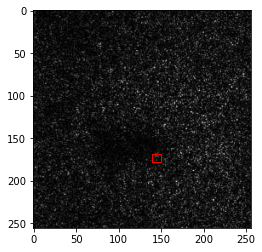

In [22]:
file_name = '/home/vanessa/Dev/DATASETS/C23_C24_pos_t/poz/img_poz_2001_04_06_19_13_00_32.jpg'
im = Image.open(file_name)
im_event = file_name.split('/',)[-1][8:27]
im_time = dt.datetime.strptime(im_event, "%Y_%m_%d_%H_%M_%S")
im_event = dt.datetime.strftime(im_time, "%d.%m.%Y %H:%M")

img_box = box_df[box_df['Time'] == im_event].iloc[0]

fig, ax = plt.subplots()
ax.imshow(im)

r = get_box(img_box.b1_cx, img_box.b1_cy, img_box.b1_w, img_box.b1_h)

ax.add_patch(r)
plt.show()